# Abusive Language Detection using Machine Learning

This tutorial shows how to detect abusive language using a different ML techniques such as `Support Vector Machine, Bayes, Tree and Random, etc` and it also compare which techniques are best for detecting abusive language and why. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Applying different Machine Learning techniques and show which ML technique is best to detect abusive language, including data pre-processing and feature extraction.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

### Tools and Techniques used in Project:

1. Anaconda (Python distribution platform)
2. Jupiter Notebook (Open source web application)
3. Python (programming language)
4. Machine Learning (Technique)

## Setup

Import Pandas and other necessary libraries:

In [1]:
import pandas as pd
import numpy as np

import googleapiclient.discovery       # the google api to get data
import googleapiclient.errors
from textblob import TextBlob
import csv

import nltk            # Natural Language Toolkit for tokenization
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

from scipy import stats

import matplotlib.pyplot as plt    # for visualization
from wordcloud import WordCloud
import seaborn as sns

import joblib          # for saving ML model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to C:\Users\Buzz
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def get_all_comments(video_id):
    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = 'your-youtube-developer-key'

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    # Initial request to get comments
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100
    )
    response = request.execute()
    
    comments = []

    # Add comments from the initial request
    for item in response['items']:
        comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
        comments.append(comment_text)
        
        reply_request = youtube.comments().list(
            part="snippet",
            parentId=item['id']
        )
        reply_response = reply_request.execute()

        # Add replies to the comments list
        for reply_item in reply_response['items']:
            reply_text = reply_item['snippet']['textDisplay']
            comments.append(reply_text)

    # Paginate through additional comments if available
    while 'nextPageToken' in response:
        nextPageToken = response['nextPageToken']
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        )
        response = request.execute()

        # Add comments from the paginated request
        for item in response['items']:
            comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment_text)
            
            reply_request = youtube.comments().list(
                part="snippet",
                parentId=item['id']
            )
            reply_response = reply_request.execute()

            # Add replies to the comments list
            for reply_item in reply_response['items']:
                reply_text = reply_item['snippet']['textDisplay']
                comments.append(reply_text)

    return comments

video_id = 'id_MB2RClG4'     # Any YouTube video id
all_comments = get_all_comments(video_id)

In [3]:
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    sentiment = analysis.sentiment.polarity

    if sentiment > 0:
        label = 'Yes'
    else:
        label = 'No'
    
    return label

In [4]:
def save_to_csv(comments, csv_file_name='youtube_comments.csv'):
    labels = []

    for comment_text in comments:
        label = analyze_sentiment(comment_text)
        labels.append(label)

    data = {'Comments': comments, 'Classes': labels}
    df = pd.DataFrame(data)
    df.to_csv(csv_file_name, index=False, encoding='utf-8')
    print(f'Data has been saved to {csv_file_name}')


save_to_csv(all_comments)

Data has been saved to youtube_comments.csv


In [2]:
df = pd.read_csv("./youtube_comments.csv")
print("There are", df["Comments"].count(), "comments in a dataset.")

There are 7411 comments in a dataset.


## Load and Explore the dataset

This tutorial uses a dataset of about 1,200 comments. The dataset contains two sub-directories, one per class:

```
Offensive Language Dataset/
  Comments/
  Classes/
```

#### Get the shape of data

In [3]:
print("Shape of the dataset is:", df.shape)

Shape of the dataset is: (7411, 2)


#### Show first 8 rows of data using data head

In [4]:
print("Showing top 8 comments of a dataset using head")
df.head(8)

Showing top 8 comments of a dataset using head


,Comments,Classes
0,Great Elon Musk ❤,Yes
1,KINGS!,No
2,Wikipedia and more such applications and websi...,Yes
3,I am 47 years old and studying English for Wri...,Yes
4,"The truth is, you have educated me a lot. Than...",No
5,“You can learn anything!” what a dream come tr...,Yes
6,"Thats what people with money should do, promot...",No
7,LOVE FROM BANGLADESH 💝💖💗💓💞💕,Yes


#### Show last 7 rows of data using data tail

In [5]:
print("Showing last 8 comments of a dataset using tail")
df.tail(8)

Showing last 8 comments of a dataset using tail


,Comments,Classes
7403,:),Yes
7404,Hi.......,No
7405,🙌🏽,No
7406,Oop,No
7407,❤❤❤❤,No
7408,first,Yes
7409,@@CharleyCheno Yes!!,No
7410,@@JewelBelleLove Yes!!,No


In [6]:
null_values = df["Comments"].isnull().sum()
print("There are" , null_values, "null values in Comments.")

There are 0 null values in Comments.


In [7]:
unique_values = df['Comments'].unique()
print("There are total", len(unique_values), "unique values before data pre-processing.")

There are total 7138 unique values before data pre-processing.


In [8]:
print("The type of dataset is:")
df.dtypes

The type of dataset is:


Comments    object
Classes     object
dtype: object

In [9]:
print("This describes you the statistical summary of a dataset:\n")
df.describe()

This describes you the statistical summary of a dataset:



,Comments,Classes
count,7411,7411
unique,7138,2
top,Nice,No
freq,16,3773


In [10]:
print("This describes you the metadata of a dataset:")
df.info()

This describes you the metadata of a dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7411 entries, 0 to 7410
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  7411 non-null   object
 1   Classes   7411 non-null   object
dtypes: object(2)
memory usage: 115.9+ KB


## Data Pre-processing

As most of the data in the real world are incomplete containing noisy and missing
values. So we apply the followimg pre-processing techniques to the data.

1. Normalize the dataset.
2. Handle stop words.
3. Missing values.
4. Noise & Outliers
5. Remove duplicate values.

### Normalize the dataset

We are converting rows and column of a dataset into `lowercase` and then remove the `special characters, punctuation, and numbers` and then we are removing the `spaces` also.

`re` is a python module that stands for "regular expression". It provides support for regular expressions, which are a powerful and flexible way to search, match, and manipulate strings based on specific patterns.

In [11]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Replace the sample data with your actual data
comments_rows = df["Comments"]

classes_rows = df["Classes"]

# Create a DataFrame using your actual data
data = {'comments': comments_rows, 'classes': classes_rows}
df = pd.DataFrame(data)

# Apply text cleaning to the "comments" column in the DataFrame
df['comments'] = df['comments'].apply(clean_text)

# Print the cleaned DataFrame
print("After converting rows and columns into lowercase\n", df)

After converting rows and columns into lowercase
                                                comments classes
0                                       great elon musk     Yes
1                                                 kings      No
2     wikipedia and more such applications and websi...     Yes
3     i am years old and studying english for writer...     Yes
4     the truth is you have educated me a lot thank you      No
...                                                 ...     ...
7406                                                oop      No
7407                                                         No
7408                                              first     Yes
7409                                   charleycheno yes      No
7410                                 jewelbellelove yes      No

[7411 rows x 2 columns]


### Handling Stop Words

The Natural Language Toolkit (NLTK) library in Python provides a list of common stop words that you can use to remove stop words from your text data. Examples of stop words in English includes `the`, `and`, `in`, `of`, `to`, and so on.

In [12]:
# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Replace the sample data with your actual data
data = {'comments': df["comments"], 'classes': df["classes"]}

# Create a DataFrame using your actual data
df = pd.DataFrame(data)

# Apply stop word removal to the "comments" column in the DataFrame
df['comments'] = df['comments'].apply(remove_stopwords)

# Print the DataFrame with stop words removed
print("After handling stopwords\n", df)

After handling stopwords
                                                comments classes
0                                       great elon musk     Yes
1                                                 kings      No
2     wikipedia applications website provide physics...     Yes
3     years old studying english writers first time ...     Yes
4                              truth educated lot thank      No
...                                                 ...     ...
7406                                                oop      No
7407                                                         No
7408                                              first     Yes
7409                                   charleycheno yes      No
7410                                 jewelbellelove yes      No

[7411 rows x 2 columns]


### Removing Duplicate Comments

We are removing duplicates comments here

In [13]:
data = {
    'comments': df["comments"],
    'classes': df["classes"]
}

df = pd.DataFrame(data)

# Count the number of duplicate values before removing
duplicate_comments_sum = df.duplicated(subset='comments').sum()

# Create a Series of boolean values indicating duplicate comments
original_duplicates = df.duplicated(subset='comments')

# Extract the duplicate comments using the boolean mask
duplicate_comments = df.loc[original_duplicates, 'comments']

# CSV file in which only duplicates comments
duplicate_comments.to_csv('duplicates_comments.csv', index=False)

# Print
print("Duplicate Comments:", duplicate_comments_sum)
print("Duplicated Comments are below:\n", duplicate_comments)

Duplicate Comments: 869
Duplicated Comments are below:
 17      oh jiminy crickets
18      oh jiminy crickets
47                        
48         love bangladesh
76                        
               ...        
7403                      
7404                    hi
7405                      
7407                      
7408                 first
Name: comments, Length: 869, dtype: object


In [14]:
# Remove duplicates from column 'comments' and keep the first occurrence
df = df.drop_duplicates(subset='comments', keep='first')

# Count the number of duplicate values after removing
removed_duplicates_count = duplicate_comments_sum - df.duplicated(subset='comments').sum()

print("Number of Duplicated Comments Removed:", removed_duplicates_count)

Number of Duplicated Comments Removed: 869


### Exploring the Data after Data Pre-processing

Here, you can see that after removing duplicates comments. No. of Comments Decreased to 1268.

In [15]:
print("There are", df["comments"].count(), "comments in a dataset after data pre-processing.")

There are 6542 comments in a dataset after data pre-processing.


In [16]:
df.describe()

,comments,classes
count,6542,6542
unique,6542,2
top,great elon musk,Yes
freq,1,3308


In [17]:
print("Shape of the dataset is:", df.shape)

Shape of the dataset is: (6542, 2)


### Z-Scores & Outliers

In [18]:
data = {
    'comments': df['comments'],
    'classes': df['classes']
}

df = pd.DataFrame(data)

# Calculate the mean and standard deviation of the Z-Scores
mean = np.mean(df['comments'].str.len())
std_dev = np.std(df['comments'].str.len())

# Calculate Z-Scores for each data point
df['z_scores'] = (df['comments'].str.len() - mean) / std_dev

# Define a threshold for identifying outliers
threshold = 2

# Identify outliers based on the threshold
outliers = df[df['z_scores'].abs() > threshold]

# Print the Z-Scores and outliers
print("Z-Scores:\n", df[['comments', 'z_scores']])
print("\nThere are", len(outliers[['comments', 'z_scores']]), "Outliers detected.")
print("\nOutliers:\n", outliers[['comments', 'z_scores']])

Z-Scores:
                                                comments  z_scores
0                                       great elon musk -0.598470
1                                                 kings -0.760416
2     wikipedia applications website provide physics...  0.729488
3     years old studying english writers first time ...  6.203265
4                              truth educated lot thank -0.452719
...                                                 ...       ...
7401                            first view like comment -0.468913
7402                                       sal type gal -0.647054
7406                                                oop -0.792806
7409                                   charleycheno yes -0.582276
7410                                 jewelbellelove yes -0.549886

[6542 rows x 2 columns]

There are 213 Outliers detected.

Outliers:
                                                comments  z_scores
3     years old studying english writers first time ...  6.2

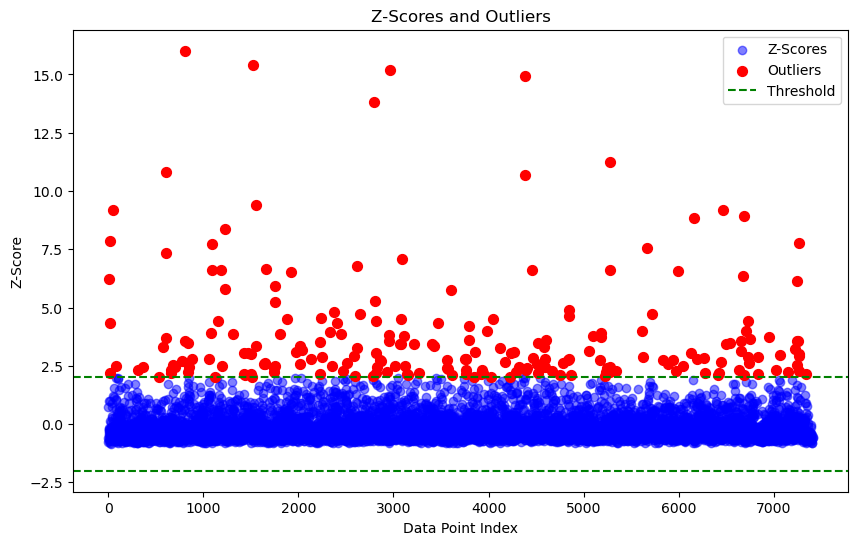

In [19]:
# Create a scatter plot to visualize the Z-scores and outliers
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['z_scores'], color = 'blue', label = 'Z-Scores', alpha = 0.5)
plt.scatter(outliers.index, outliers['z_scores'], color = 'red', label = 'Outliers', marker = 'o', s = 50)
plt.axhline(y = threshold, color = 'green', linestyle = '--', label = 'Threshold')
plt.axhline(y = -threshold, color = 'green', linestyle = '--')
plt.legend()
plt.title('Z-Scores and Outliers')
plt.xlabel('Data Point Index')
plt.ylabel('Z-Score')
plt.show()

In [20]:
# Before removing outliers
original_size = len(df)

# After removing outliers
df = df[df['z_scores'].abs() <= threshold]
cleaned_size = len(df)

print("Original DataFrame size:", original_size)
print("Cleaned DataFrame size (without outliers):", cleaned_size)

Original DataFrame size: 6542
Cleaned DataFrame size (without outliers): 6329


In [21]:
# Remove outliers from the DataFrame
df_no_outliers = df[df['z_scores'].abs() <= threshold]

# Print the Z-Scores and outliers
print("Z-Scores:\n", df[['comments', 'z_scores']])
print("\nThere are", len(outliers[['comments', 'z_scores']]), "Outliers detected.")
print("\nOutliers:\n", outliers[['comments', 'z_scores']])

Z-Scores:
                                                comments  z_scores
0                                       great elon musk -0.598470
1                                                 kings -0.760416
2     wikipedia applications website provide physics...  0.729488
4                              truth educated lot thank -0.452719
5                  learn anything dream come true thank -0.258383
...                                                 ...       ...
7401                            first view like comment -0.468913
7402                                       sal type gal -0.647054
7406                                                oop -0.792806
7409                                   charleycheno yes -0.582276
7410                                 jewelbellelove yes -0.549886

[6329 rows x 2 columns]

There are 213 Outliers detected.

Outliers:
                                                comments  z_scores
3     years old studying english writers first time ...  6.2

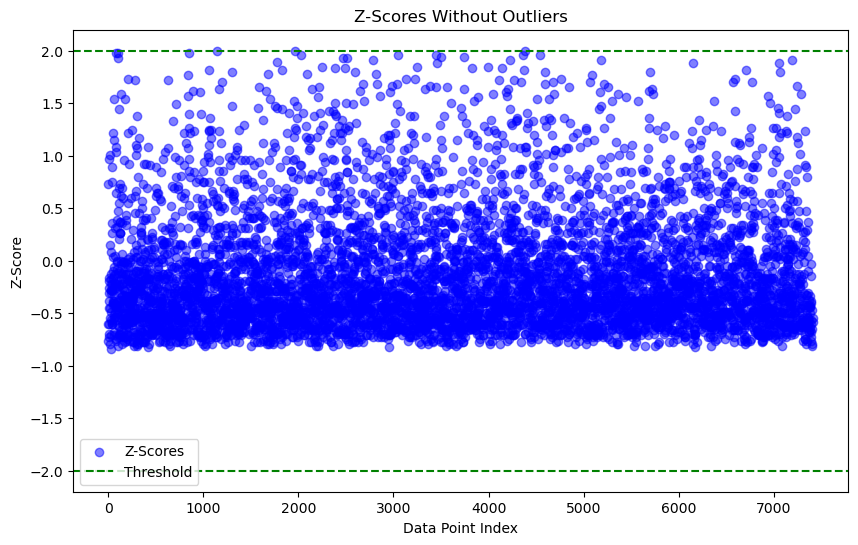

In [23]:
# Create a scatter plot to visualize the Z-scores without outliers
plt.figure(figsize=(10, 6))
plt.scatter(df_no_outliers.index, df_no_outliers['z_scores'], color='blue', label='Z-Scores', alpha=0.5)
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='green', linestyle='--')
plt.legend()
plt.title('Z-Scores Without Outliers')
plt.xlabel('Data Point Index')
plt.ylabel('Z-Score')
plt.show()

## Train & Test Data

According to requriments we are spliting data into 70% training and 30% testing data sets.

In [24]:
X = df['comments']
y = df['classes']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42)

## Feature Extraction

I am using `TF-IDF (Term Frequency-Inverse Document Frequency)` because it measures the importance of words, it capture both individual words and multi-word phrases by adjusting the n-gram range, it automatically downweights common stop words (e.g., "the", "and", "is", etc) and TF-IDF is a widely used feature extraction method in text classification tasks, including sentiment analysis and abusive language detection. That's waht i choose TF-IDF method.

In [25]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Machine learning Techniques

We are applying different classifiers/models for Machine learning Techniques like Naïve Bayes, Naïve Bayes Multinomial,
Poly Kernel, RBF Kernel, Decision Tree, Random Tree or Random Forest Tree, etc.

### Naïve Bayes

In [26]:
# for Naïve Bayes
from sklearn.naive_bayes import MultinomialNB

# Create an instance of the classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier on the TF-IDF transformed data
naive_bayes_classifier.fit(X_train_tfidf, y_train)

# Save the Naïve Bayes model
joblib.dump(naive_bayes_classifier, 'naive_bayes_model.joblib')

['naive_bayes_model.joblib']

In [27]:
from sklearn.metrics import classification_report as classification_report_naivebayes

# Load the Naïve Bayes model
loaded_naive_bayes_classifier = joblib.load('naive_bayes_model.joblib')

# Make predictions on the test data using the loaded model
y_pred = loaded_naive_bayes_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
naivebayes_accuracy = accuracy_score(y_test, y_pred)
nb_classification_report_str = classification_report_naivebayes(y_test, y_pred)

# Print the results
print("Accuracy:", naivebayes_accuracy)
print("Classification Report:\n", nb_classification_report_str)

Accuracy: 0.7962085308056872
Classification Report:
               precision    recall  f1-score   support

          No       0.89      0.67      0.77       943
         Yes       0.74      0.92      0.82       956

    accuracy                           0.80      1899
   macro avg       0.81      0.80      0.79      1899
weighted avg       0.81      0.80      0.79      1899



Confusion Matrix (Naïve Bayes):
 [[635 308]
 [ 79 877]]


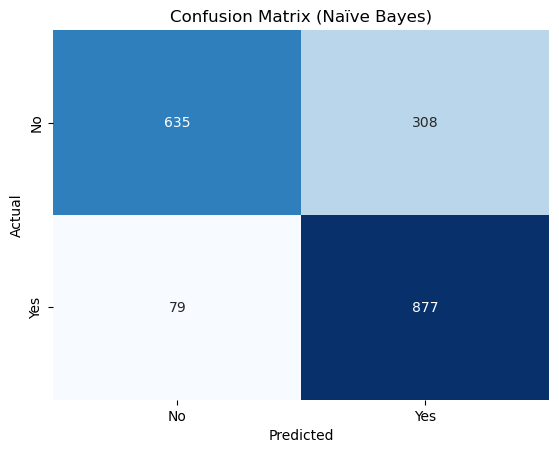

In [28]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for Random Forest Tree
conf_matrix_nb = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (Naïve Bayes):\n", conf_matrix_nb)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_naive_bayes_classifier.classes_,
            yticklabels=loaded_naive_bayes_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naïve Bayes)')
plt.show()

### Naïve Bayes Multinomial

In [29]:
# for Naïve Bayes Multinomial
from sklearn.naive_bayes import MultinomialNB

# Create an instance of the classifier
nb_classifier = MultinomialNB()

# Train the classifier on the TF-IDF transformed data
nb_classifier.fit(X_train_tfidf, y_train)

# Save the Naïve Bayes model
joblib.dump(nb_classifier, 'naive_bayes_multinomial_model.joblib')

['naive_bayes_multinomial_model.joblib']

In [30]:
from sklearn.metrics import classification_report as classification_report_nbmn

# Load the Naïve Bayes Multinomial model
loaded_nb_classifier = joblib.load('naive_bayes_multinomial_model.joblib')

# Make predictions on the test data
y_pred_nbmn = loaded_nb_classifier.predict(X_test_tfidf)

# Model evaluation
accuracy_nbmn = accuracy_score(y_test, y_pred_nbmn)
nbm_classification_report_str = classification_report_nbmn(y_test, y_pred_nbmn)

print("Accuracy:", accuracy_nbmn)
print("Classification Report:\n", nbm_classification_report_str)

Accuracy: 0.7962085308056872
Classification Report:
               precision    recall  f1-score   support

          No       0.89      0.67      0.77       943
         Yes       0.74      0.92      0.82       956

    accuracy                           0.80      1899
   macro avg       0.81      0.80      0.79      1899
weighted avg       0.81      0.80      0.79      1899



Confusion Matrix (Naïve Bayes Multinomial):
 [[635 308]
 [ 79 877]]


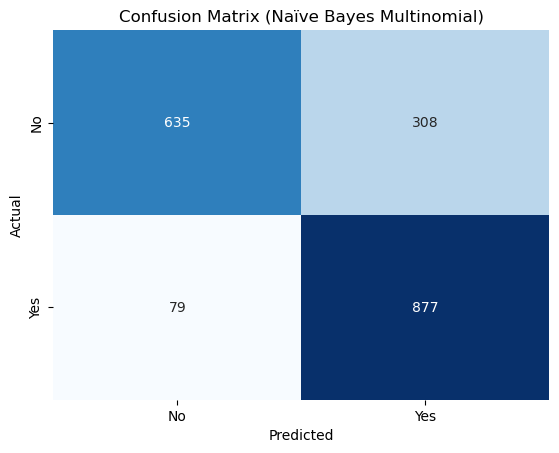

In [31]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for Naïve Bayes Multinomial
conf_matrix_nbmn = confusion_matrix(y_test, y_pred_nbmn)

print("Confusion Matrix (Naïve Bayes Multinomial):\n", conf_matrix_nbmn)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix_nbmn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_nb_classifier.classes_,
            yticklabels=loaded_nb_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naïve Bayes Multinomial)')
plt.show()

### Decision Tree

In [32]:
# for Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Create and train the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state = 42)

decision_tree_classifier.fit(X_train_tfidf, y_train)

# Save the Decision Tree model
joblib.dump(decision_tree_classifier, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

In [33]:
from sklearn.metrics import classification_report as classification_report_decisiontree

# Load the Decision Tree model
loaded_decision_tree_classifier = joblib.load('decision_tree_model.joblib')

# Make predictions on the test data
y_pred_decisiontree = loaded_decision_tree_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
decisiontree_accuracy = accuracy_score(y_test, y_pred_decisiontree)
decision_classification_report_str = classification_report_decisiontree(y_test, y_pred_decisiontree)

print("Accuracy:", decisiontree_accuracy)
print("Classification Report:\n", decision_classification_report_str)

Accuracy: 0.8741442864665614
Classification Report:
               precision    recall  f1-score   support

          No       0.87      0.88      0.87       943
         Yes       0.88      0.87      0.87       956

    accuracy                           0.87      1899
   macro avg       0.87      0.87      0.87      1899
weighted avg       0.87      0.87      0.87      1899



Confusion Matrix (Decision Tree):
 [[832 111]
 [128 828]]


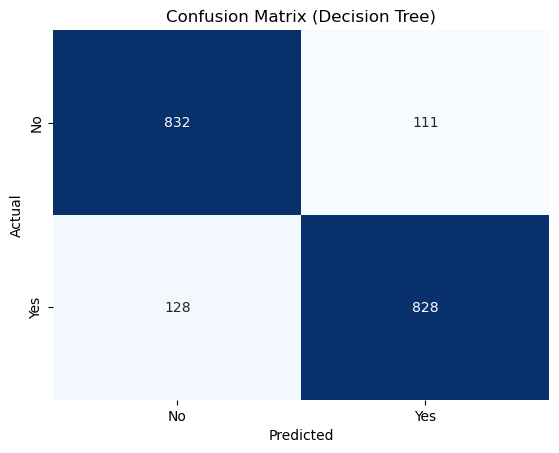

In [34]:
# Confusion matrix for Decision Tree
conf_matrix_decisiontree = confusion_matrix(y_test, y_pred_decisiontree)

print("Confusion Matrix (Decision Tree):\n", conf_matrix_decisiontree)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix_decisiontree, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_decision_tree_classifier.classes_,
            yticklabels=loaded_decision_tree_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

### Random Forest Tree

In [35]:
# for Random Forest Tree
from sklearn.ensemble import RandomForestClassifier  # for classification

# Create and train the Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_model.fit(X_train_tfidf, y_train)

# Save the Decision Tree model
joblib.dump(random_forest_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [36]:
from sklearn.metrics import classification_report as classification_report_ramdonforest

# Create and train the Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')

# Load the Random Forest model
loaded_random_forest_model = joblib.load('random_forest_model.joblib')

# Make predictions on the test data
y_pred_randomforest = loaded_random_forest_model.predict(X_test_tfidf)

# Evaluate the model's performance
randomforest_accuracy = accuracy_score(y_test, y_pred_randomforest)
random_classification_report_str = classification_report_ramdonforest(y_test, y_pred_randomforest)

print("Accuracy:", randomforest_accuracy)
print("Classification Report:\n", random_classification_report_str)

Accuracy: 0.8867825171142707
Classification Report:
               precision    recall  f1-score   support

          No       0.85      0.94      0.89       943
         Yes       0.93      0.84      0.88       956

    accuracy                           0.89      1899
   macro avg       0.89      0.89      0.89      1899
weighted avg       0.89      0.89      0.89      1899



Confusion Matrix (Random Forest Tree):
 [[884  59]
 [156 800]]


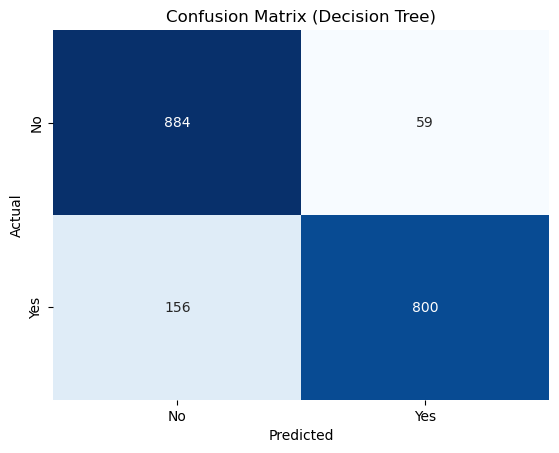

In [37]:
# Confusion matrix for Random Forest Tree
conf_matrix_randomforest = confusion_matrix(y_test, y_pred_randomforest)

print("Confusion Matrix (Random Forest Tree):\n", conf_matrix_randomforest)

sns.heatmap(conf_matrix_randomforest, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_random_forest_model.classes_,
            yticklabels=loaded_random_forest_model.classes_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

In [40]:
result_data = {
    'ML Model': ['Naïve Bayes', 'Naïve Bayes Multinomial', 'Decision Tree', 'Random Forest Tree'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
}

def extract_metrics(accuracy_value, report_str):
    accuracy = accuracy_value
    lines = report_str.split('\n')
    precision, recall, f1_score = map(float, lines[2].split()[1:4])
    return [accuracy, precision, recall, f1_score]

# Naive Bayes Metrics
accuracy_nb, precision_nb, recall_nb, f1_score_nb = extract_metrics(naivebayes_accuracy, nb_classification_report_str)
result_data['Accuracy'].append(naivebayes_accuracy)
result_data['Precision'].append(precision_nb)
result_data['Recall'].append(recall_nb)
result_data['F1-Score'].append(f1_score_nb)

# Naive Bayes Multinomial Metrics
accuracy_nbmn, precision_nbmn, recall_nbmn, f1_score_nbmn = extract_metrics(accuracy_nbmn, nbm_classification_report_str)
result_data['Accuracy'].append(accuracy_nbmn)
result_data['Precision'].append(precision_nbmn)
result_data['Recall'].append(recall_nbmn)
result_data['F1-Score'].append(f1_score_nbmn)

# Decision Tree Metrics
accuracy_decisiontree, precision_decisiontree, recall_decisiontree, f1_score_decisiontree = extract_metrics(decisiontree_accuracy, decision_classification_report_str)
result_data['Accuracy'].append(accuracy_decisiontree)
result_data['Precision'].append(precision_decisiontree)
result_data['Recall'].append(recall_decisiontree)
result_data['F1-Score'].append(f1_score_decisiontree)

# Random Forest Metrics
accuracy_randomforest, precision_randomforest, recall_randomforest, f1_score_randomforest = extract_metrics(randomforest_accuracy, random_classification_report_str)
result_data['Accuracy'].append(accuracy_randomforest)
result_data['Precision'].append(precision_randomforest)
result_data['Recall'].append(recall_randomforest)
result_data['F1-Score'].append(f1_score_randomforest)

data = pd.DataFrame(result_data)
print(data)

                  ML Model  Accuracy  Precision  Recall  F1-Score
0              Naïve Bayes  0.796209       0.89    0.67      0.77
1  Naïve Bayes Multinomial  0.796209       0.89    0.67      0.77
2            Decision Tree  0.874144       0.87    0.88      0.87
3       Random Forest Tree  0.886783       0.85    0.94      0.89


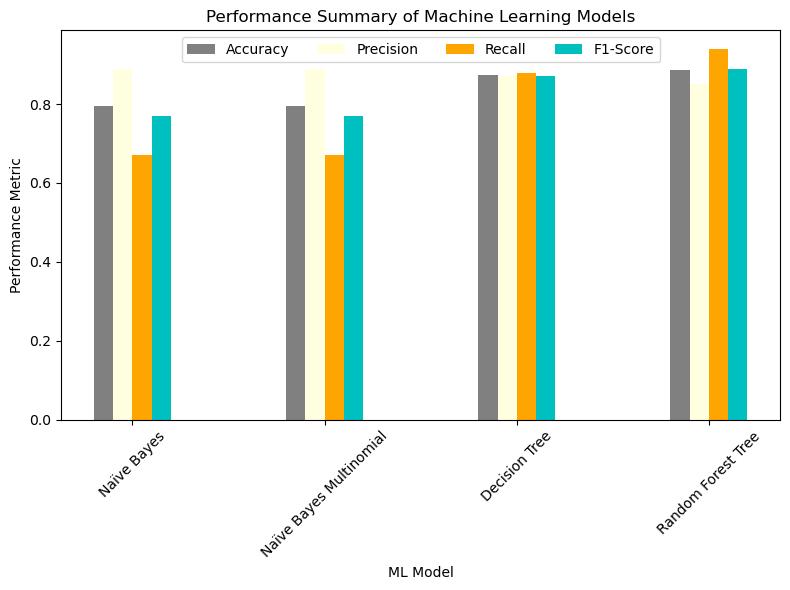

In [41]:
plt.figure(figsize=(8, 6))
plt.xlabel('ML Model')
plt.ylabel('Performance Metric')

# Create a bar chart
bar_width = 0.1
index = np.arange(len(data['ML Model']))

plt.bar(index, data['Accuracy'], bar_width, label='Accuracy', color='grey')
plt.bar(index + bar_width, data['Precision'], bar_width, label='Precision', color='lightyellow')
plt.bar(index + bar_width * 2, data['Recall'], bar_width, label='Recall', color='orange')
plt.bar(index + bar_width * 3, data['F1-Score'], bar_width, label='F1-Score', color='c')

plt.xticks(index + bar_width * 1.5, data['ML Model'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.title('Performance Summary of Machine Learning Models')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
print('Happy Learning')

Happy Learning
